# Processing precipitation data for PISM paleo simulations
The goal of this script is to take the RACMO reference data and temperature forcing data from http://www.pik-potsdam.de/~albrecht/pism_paleo_climate/, and combining it with ice elevation data and precipitation forcing factor from PISM results from https://raw.githubusercontent.com/ldeo-glaciology/pangeo-pismpaleo/main/paleopism.yaml to get a 7D xarray that lines up with the snapshots1ka from the paleo PISM runs. The 7 dimensions are 125 time steps, a 361x361 spatial grid, and 4x4x4x4 forcing factors (but only one of them impacts precipitation forcing). 

In [1]:
import intake
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt


Display Precipitation reference

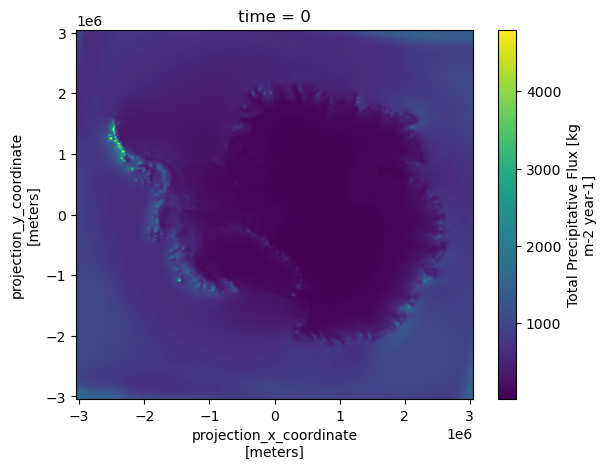

In [2]:
ds_surface_ref = xr.open_dataset('racmo_wessem_mean-d1.nc')
ds_ref = ds_surface_ref.assign_coords(time=[0])
precip_ref = ds_ref.precipitation
precip_ref.plot()

Open temperature forcing

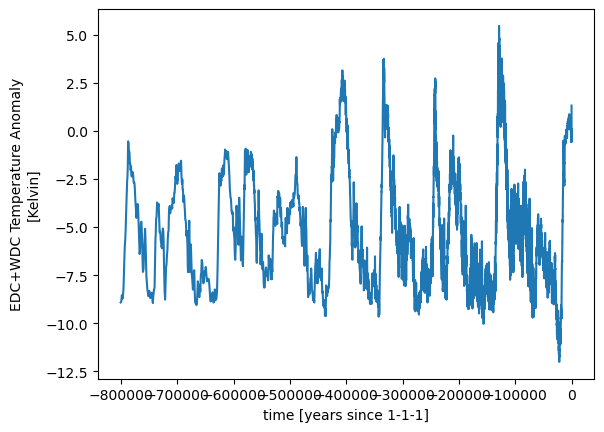

In [3]:
ds_forcing = xr.open_dataset('timeseries_edc-wdc_temp.nc',decode_times=False)
ds_forcing.delta_T.plot()

Load PISM results

In [4]:
# Made cluster and added in (address will vary)
from dask.distributed import Client

client = Client("tcp://127.0.0.1:41675")
client

<Client: 'tcp://127.0.0.1:41675' processes=4 threads=8, memory=29.39 GiB>

In [5]:
cat = intake.open_catalog('https://raw.githubusercontent.com/ldeo-glaciology/pangeo-pismpaleo/main/paleopism.yaml')
snapshots = cat["snapshots1ka"].to_dask()

In [6]:
# Reference height
ref_height = snapshots.usurf.isel(time=124)

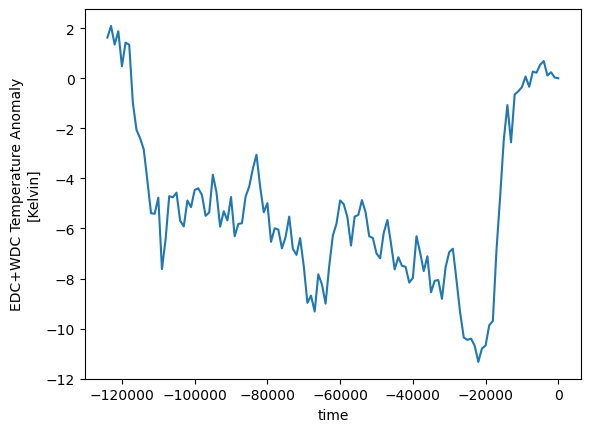

In [7]:
# Interpolate forcing onto same grid as snapshots
ds_forcing_interp = ds_forcing.interp(time=snapshots.time)
ds_forcing_interp.delta_T.plot()

Applying anomaly and expanding precipitation to be on the same grid as the velocities

In [8]:
# initial time
precip_evol = precip_ref*(1 + snapshots.par_prec*ds_forcing_interp.delta_T.isel(time=0))-0.554*(snapshots.usurf.isel(time=0)-ref_height)/1000
precip_evol = precip_evol.assign_coords(time=[snapshots.time[0]])

# iterate through each timestep
for i in range(1,len(snapshots.time)):
    precip_temp = precip_ref*(1 + snapshots.par_prec*ds_forcing_interp.delta_T.isel(time=i))-0.554*(snapshots.usurf.isel(time=i)-ref_height)/1000
    precip_temp = precip_temp.assign_coords(time=[snapshots.time[i]])
    precip_evol = xr.concat([precip_evol,precip_temp],dim='time')

In [9]:
# check resulting structure
precip_evol

,Array,Chunk
Bytes,34.61 GiB,70.88 MiB
Shape,"(125, 381, 381, 4, 4, 4, 4)","(1, 381, 381, 4, 1, 4, 4)"
Count,1124 Graph Layers,500 Chunks
Type,float64,numpy.ndarray


Looking at different mean precipitation forcing depending on precipitation setting

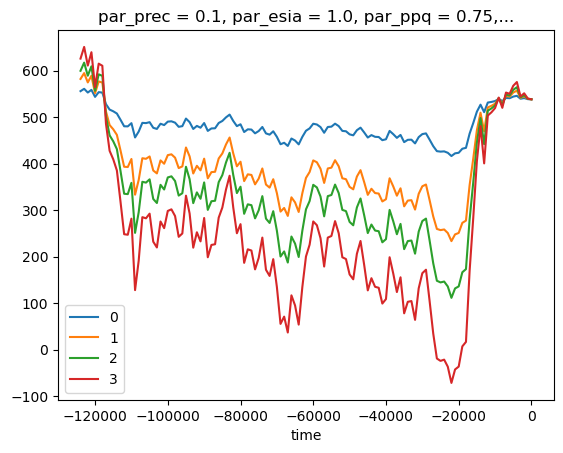

In [18]:
ax = plt.figure()
precip_evol.isel(par_esia=0,par_ppq = 2, par_prec= 0,par_visc = 2).mean(dim=['x','y']).plot(label='0')
precip_evol.isel(par_esia=0,par_ppq = 2, par_prec= 1,par_visc = 2).mean(dim=['x','y']).plot(label='1')
precip_evol.isel(par_esia=0,par_ppq = 2, par_prec= 2,par_visc = 2).mean(dim=['x','y']).plot(label='2')
precip_evol.isel(par_esia=0,par_ppq = 2, par_prec= 3,par_visc = 2).mean(dim=['x','y']).plot(label='3')
plt.legend()